# Multimodal RAG using ColPali (with Byaldi) and GPT

[Run this notebook live on Google Colab here](https://colab.research.google.com/github/jsoma/2024-ds-dojo/blob/main/04-everything/ColiPali_with_GPT.ipynb).

> Almost all of this code is adapted from [this delightful notebook](https://github.com/merveenoyan/smol-vision/blob/main/ColPali_%2B_Qwen2_VL.ipynb)

Traditionally, people used OCR to translate PDFs into a format that can be understood by an LLM. This causes a lot of problems with tables and diagrams, which cannot be understood with just text.

But now, there is a better option! [ColPali](https://huggingface.co/blog/manu/colpali) is a "multimodal retriever" that processes images along with text, removing the need for OCR.

The process below involves two parts:

1. Index your document (describe what each page is about)
2. Present your question and find relevant pages
2. Send your question to the AI with the relevant pages, and get an answer

In this example, the "index your documents" is done with ColiPali+[Byaldi](https://github.com/AnswerDotAI/byaldi), and "get an answer"  step is GPT.

## Installation

We will install byaldi and openai using pip to get started.

In [87]:
!pip install --upgrade --quiet openai byaldi transformers pdf2image flash-attn

In [88]:
!sudo apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Click the **folder icon** to the right and upload your document. My document is called `12.pdf`.

Let's look at one page of it.

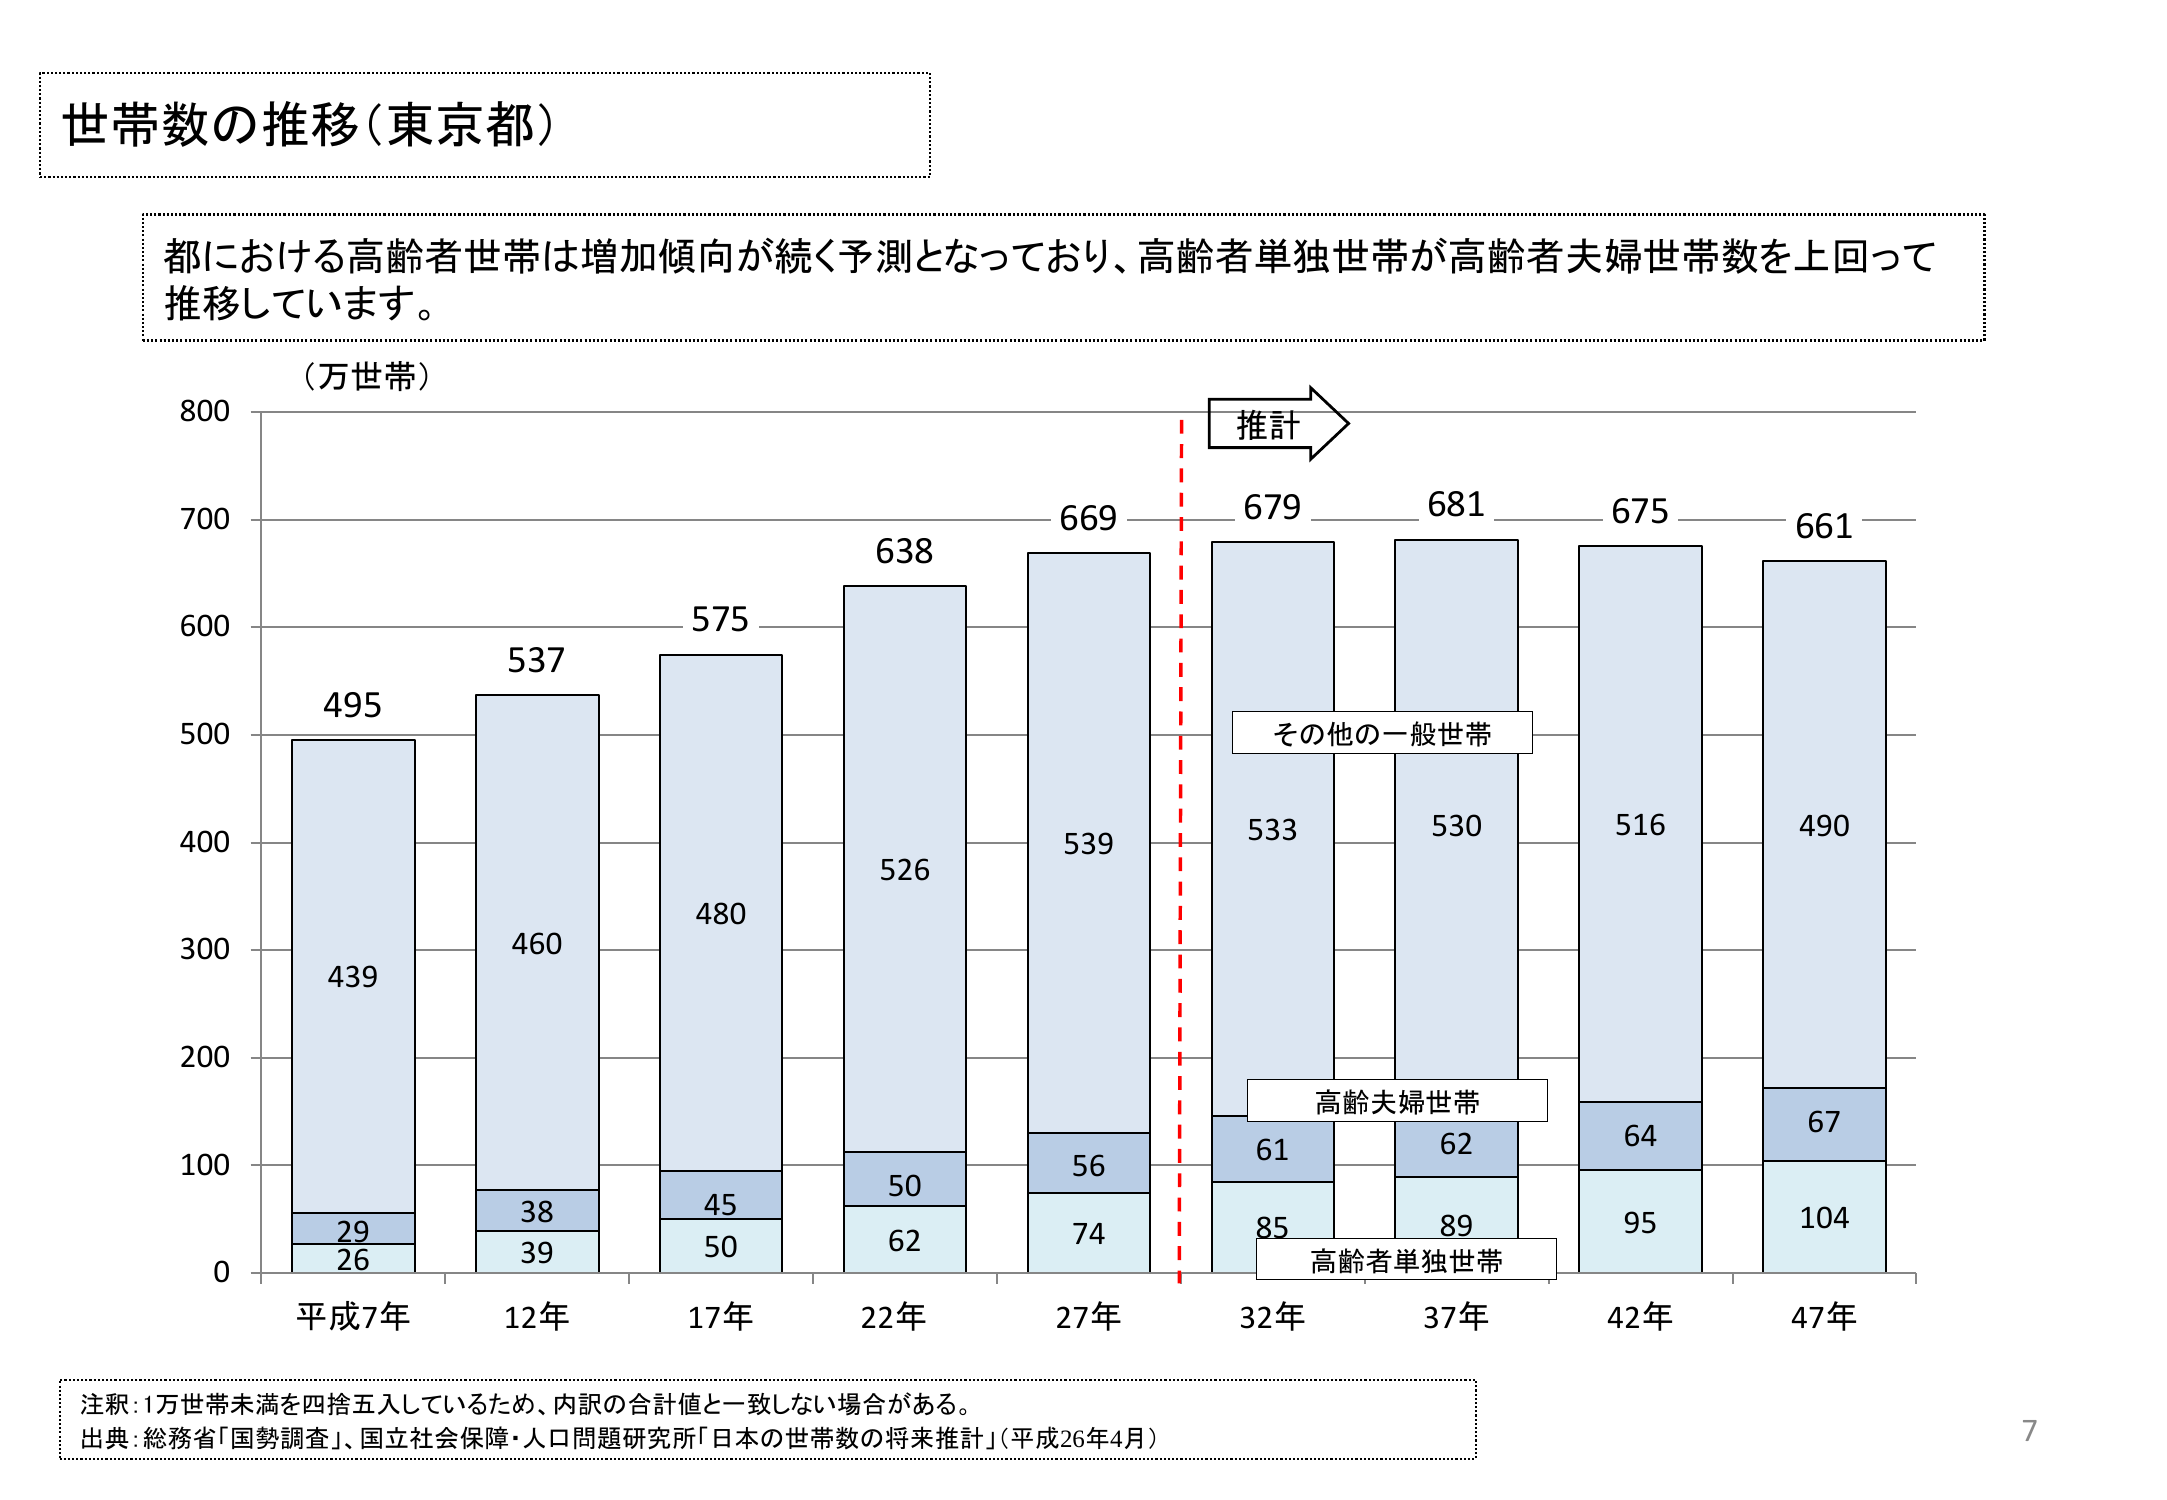

In [89]:
from pdf2image import convert_from_path

images = convert_from_path("12.pdf")
images[7]

We should initialize `RAGMultiModalModel` object with a ColPali model from Hugging Face.

1. **RAG**: Retrieval-augmented generation, the way to find related documents
2. **MultiModal**: text *and* images

This is what we will use to see what each page of our document is about.

In [90]:
from byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.2")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

We can directly index our document using RAG, simply passing pdf file path is enough.

In [91]:
RAG.index(
    input_path="12.pdf",
    index_name="image_index", # index will be saved at index_root/index_name/
    store_collection_with_index=False,
    overwrite=True
)

overwrite is on. Deleting existing index image_index to build a new one.
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Added page 17 of document 0 to index.
Added page 18 of document 0 to index.
Added page 19 of document 0 to index.
Added page 20 of document 0 to index.
Added page 21 of document 0 to index.
Added page 22 of document 0 to index.
Added page 23 of document 0 to index.
Added page 24 of document 0 to index.
Added page 25 of documen

{0: '12.pdf'}

Now let's retrieve! What are the relevant pages to our question?

In [92]:
text_query = "2015年の高齢夫婦世帯数はいくらですか？"
results = RAG.search(text_query, k=3)
results

[{'doc_id': 0, 'page_num': 23, 'score': 11.5, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 3, 'score': 11.5, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 46, 'score': 11.4375, 'metadata': {}, 'base64': None}]

We can also **look at the pages** to see if they match where we think the answers are. First we will convert them to something we can display...

In [94]:
from pdf2image import convert_from_path
from io import BytesIO
import base64

def image_to_base64(image, format="JPEG"):
    buffered = BytesIO()
    image.save(buffered, format=format, quality=85)  # Adjust quality if needed
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

relevant_images = []
for result in results:
  # The page number we think of is not the same
  # as the index (e.g. "page one" is index 0)
  index = result['page_num'] - 1
  image = images[index]

  relevant_images.append({
      'page_num': result['page_num'],
      'score': result['score'],
      'image': image,
      'encoded_image': image_to_base64(image),
  })

len(relevant_images)

3

...then we can display them in a nice table.


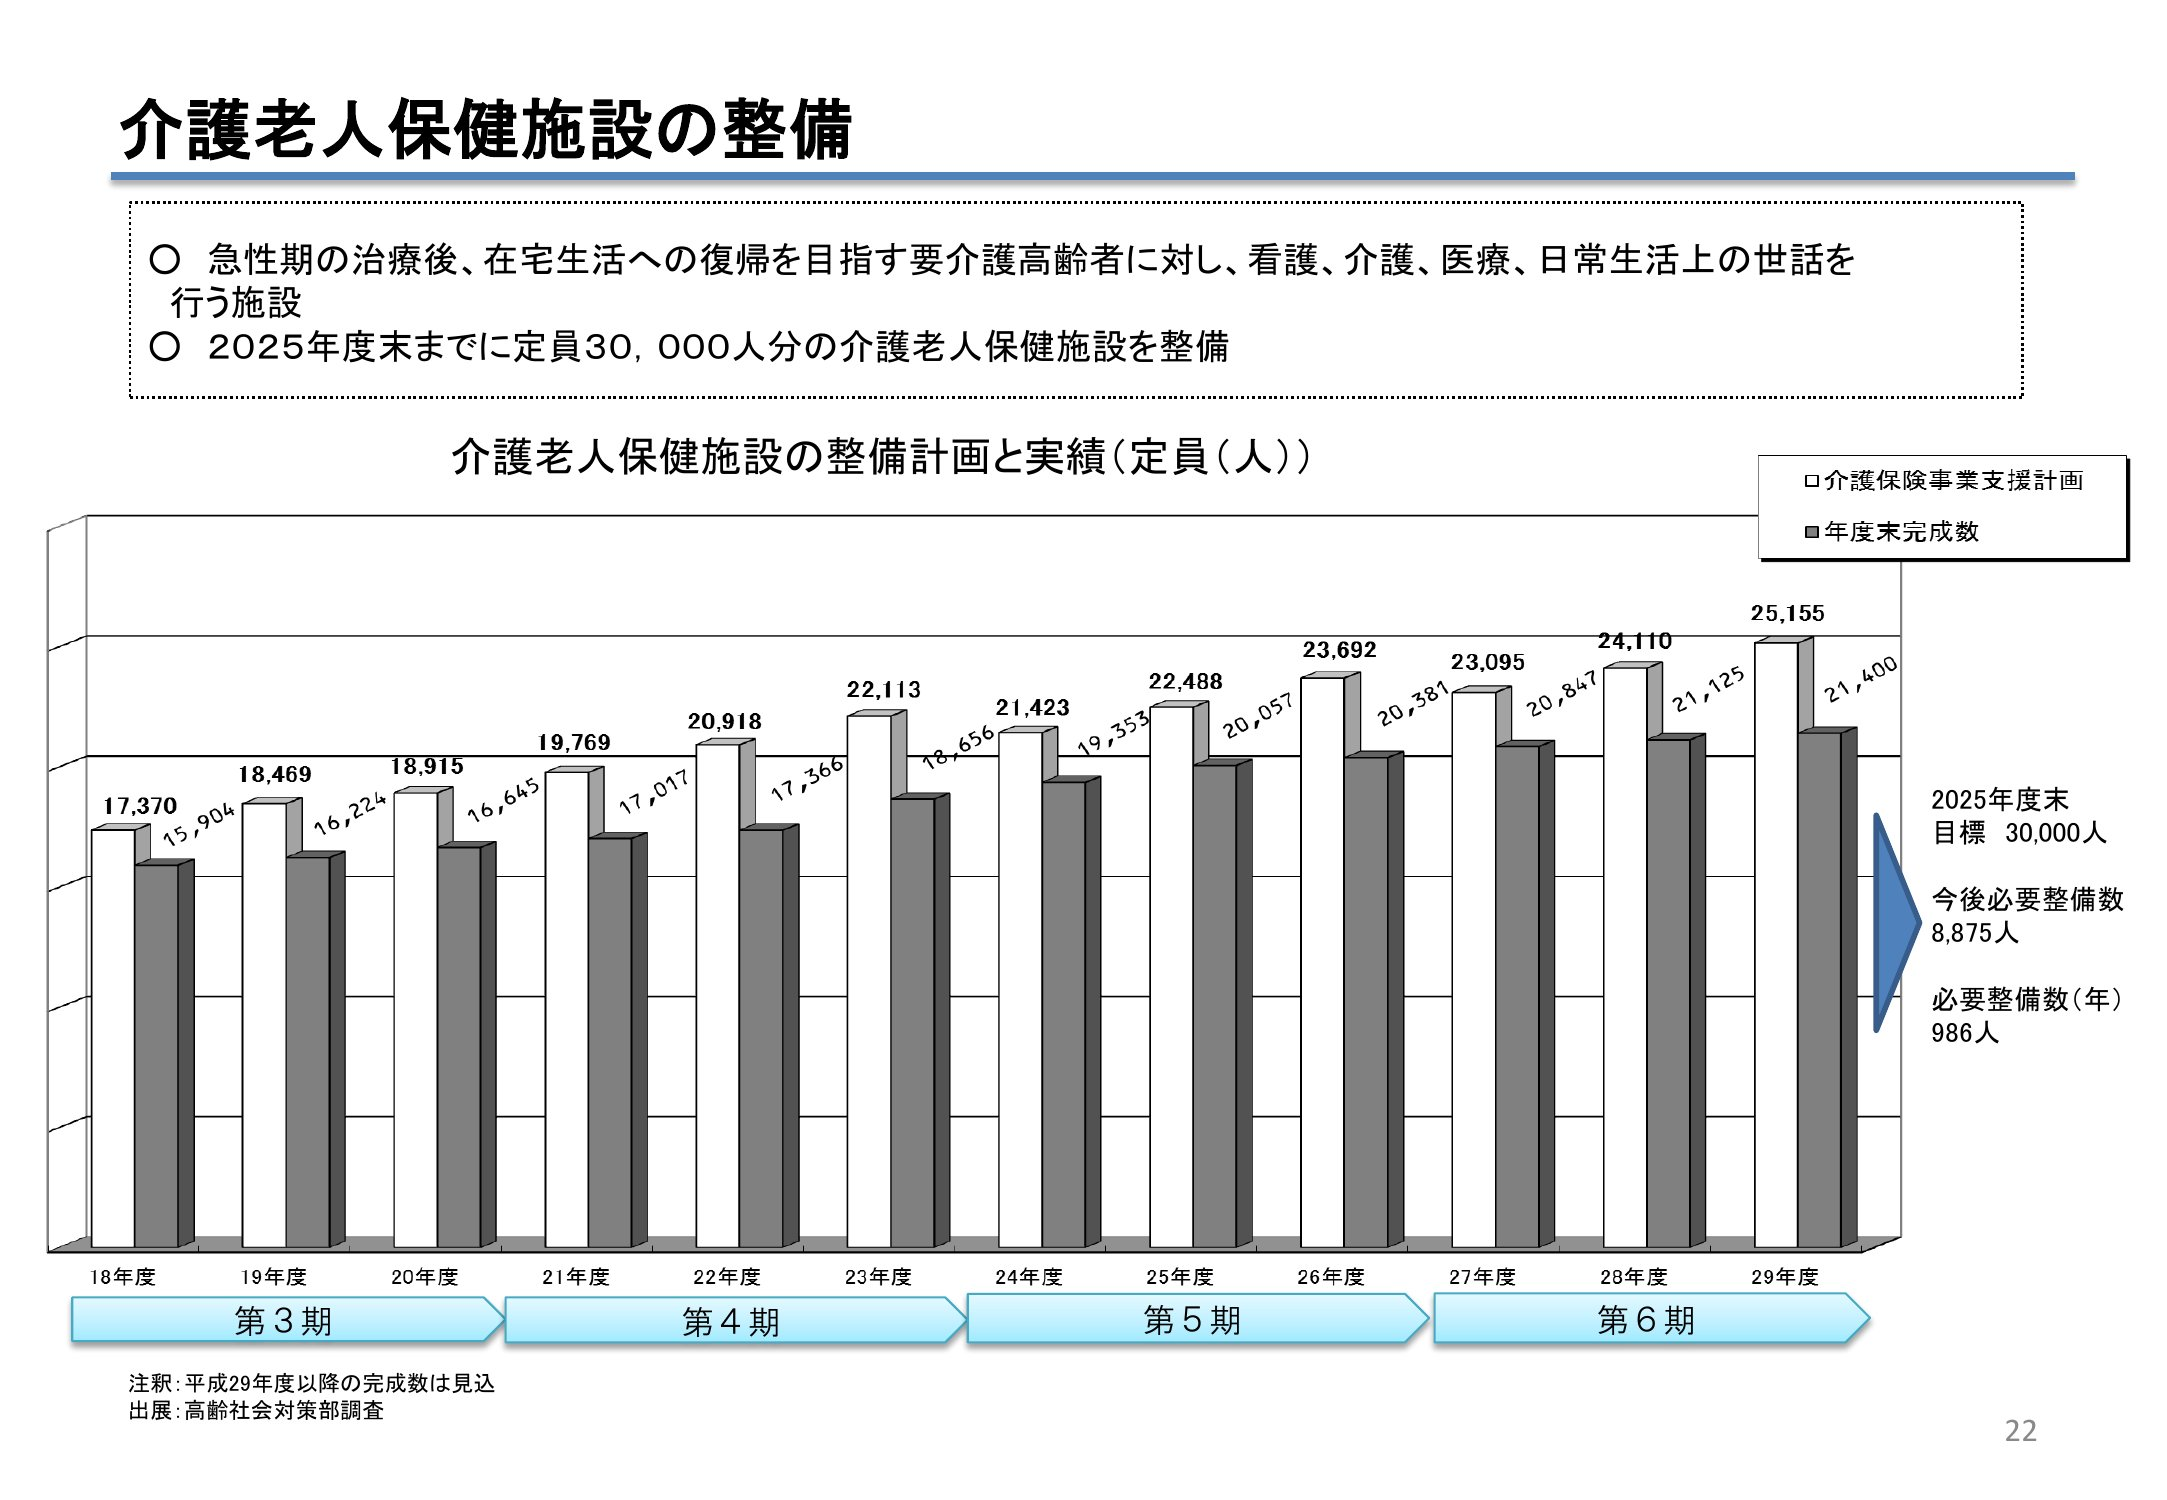
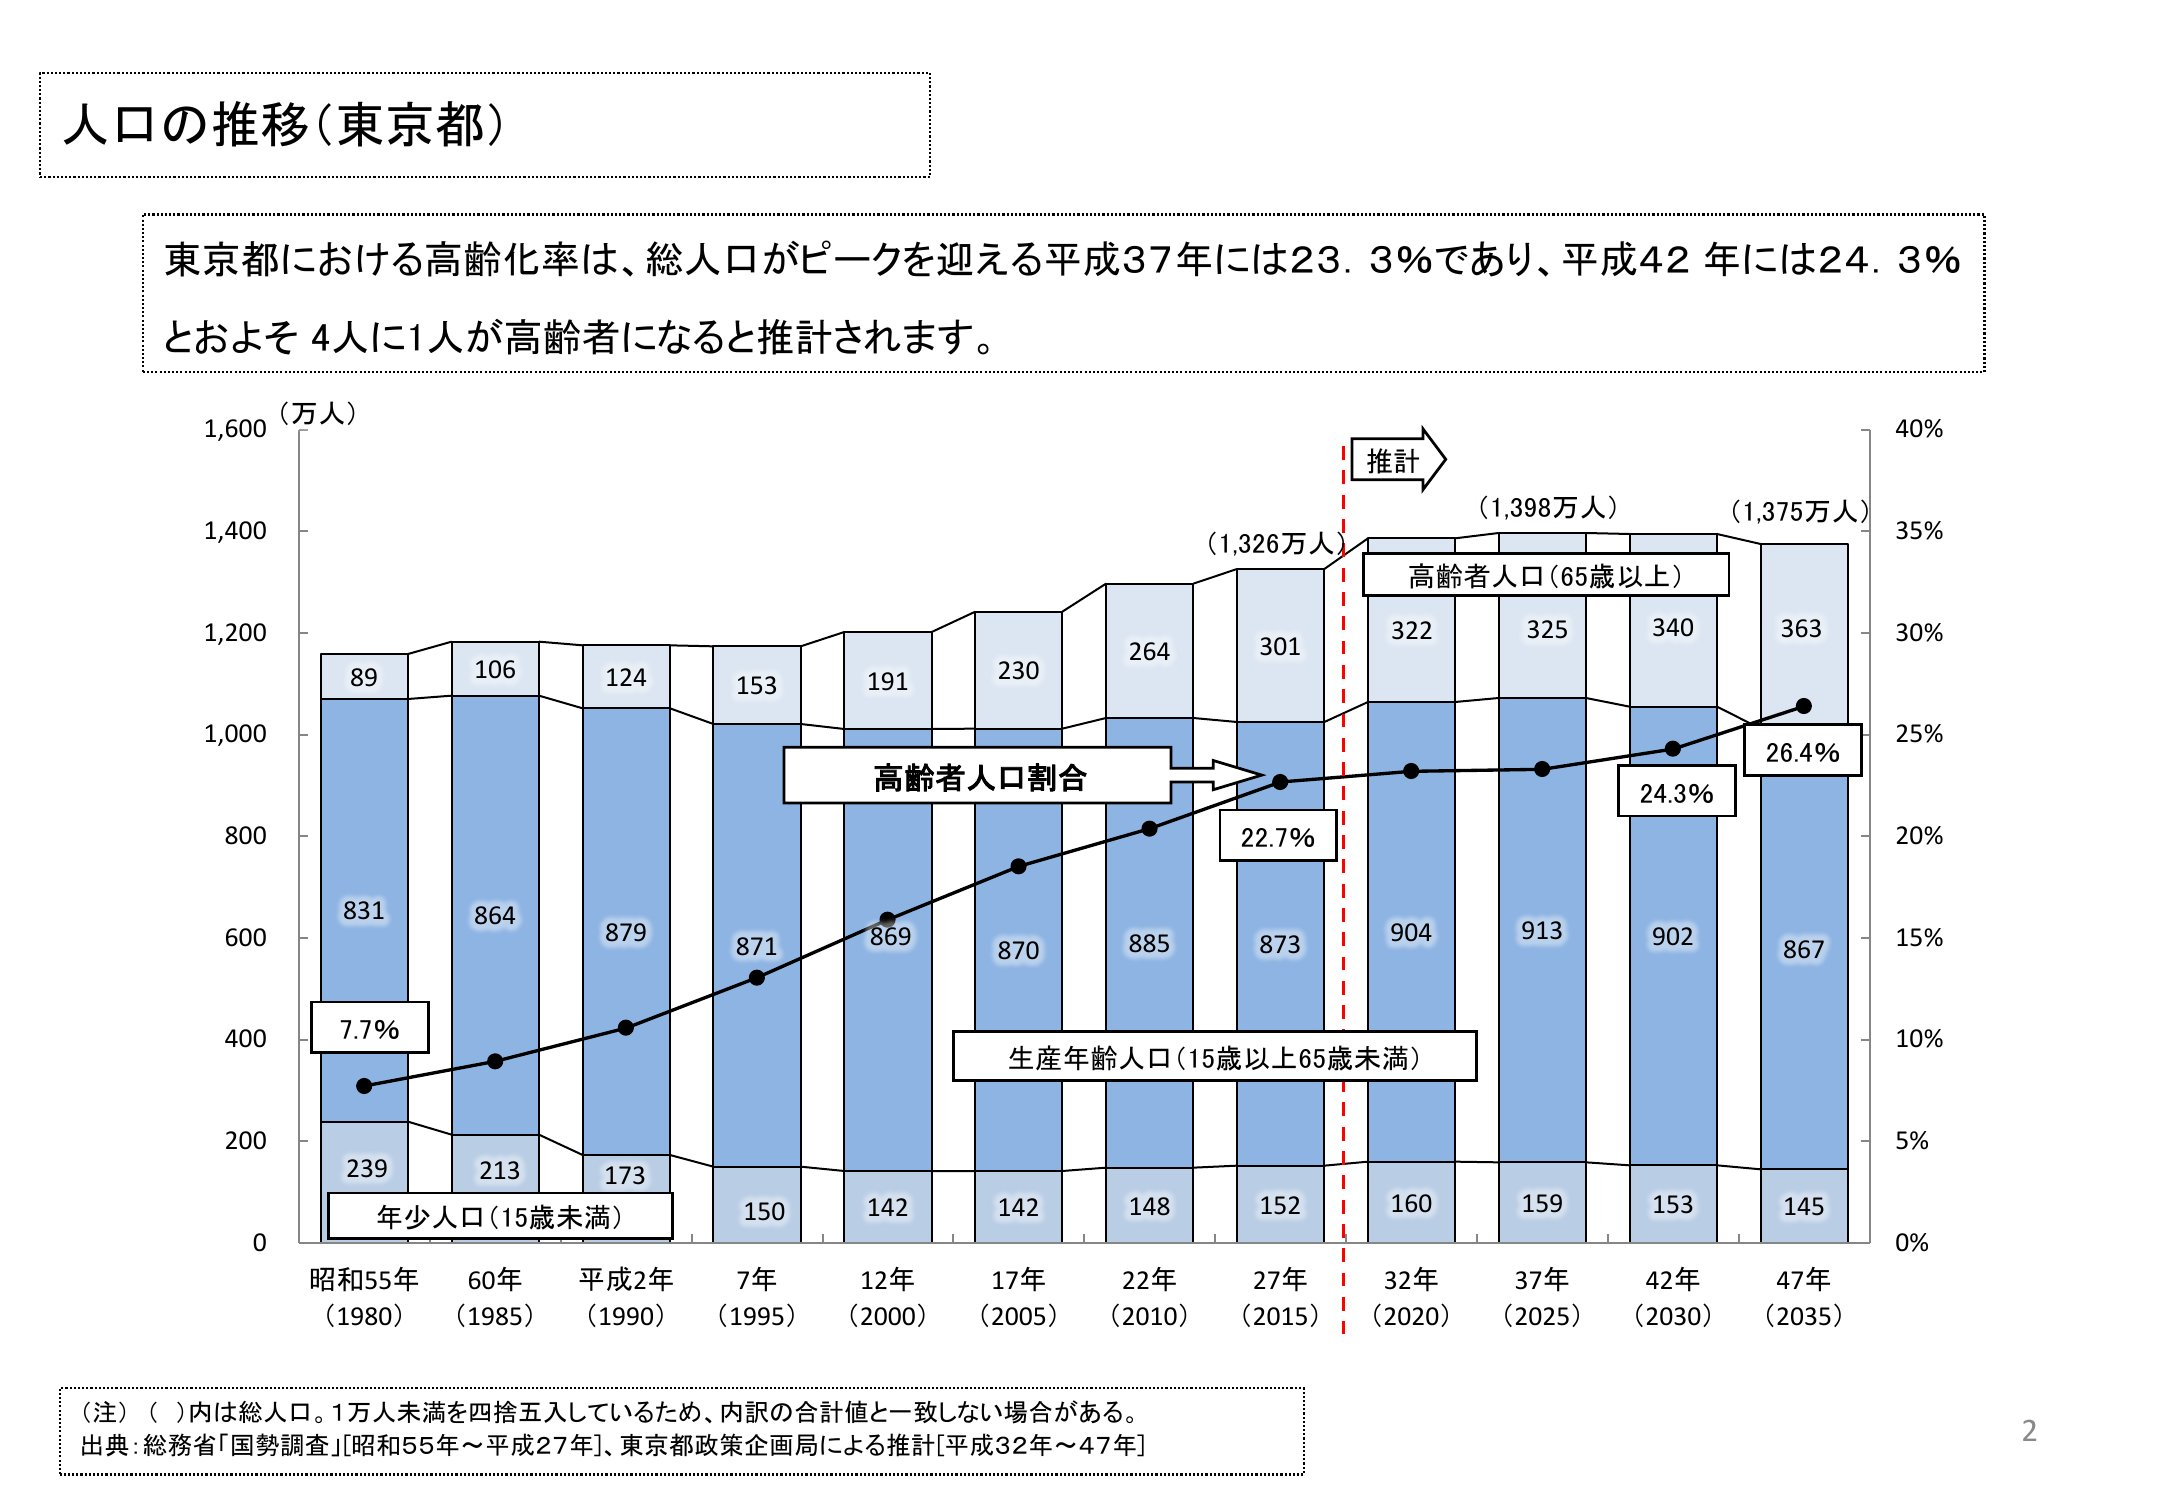
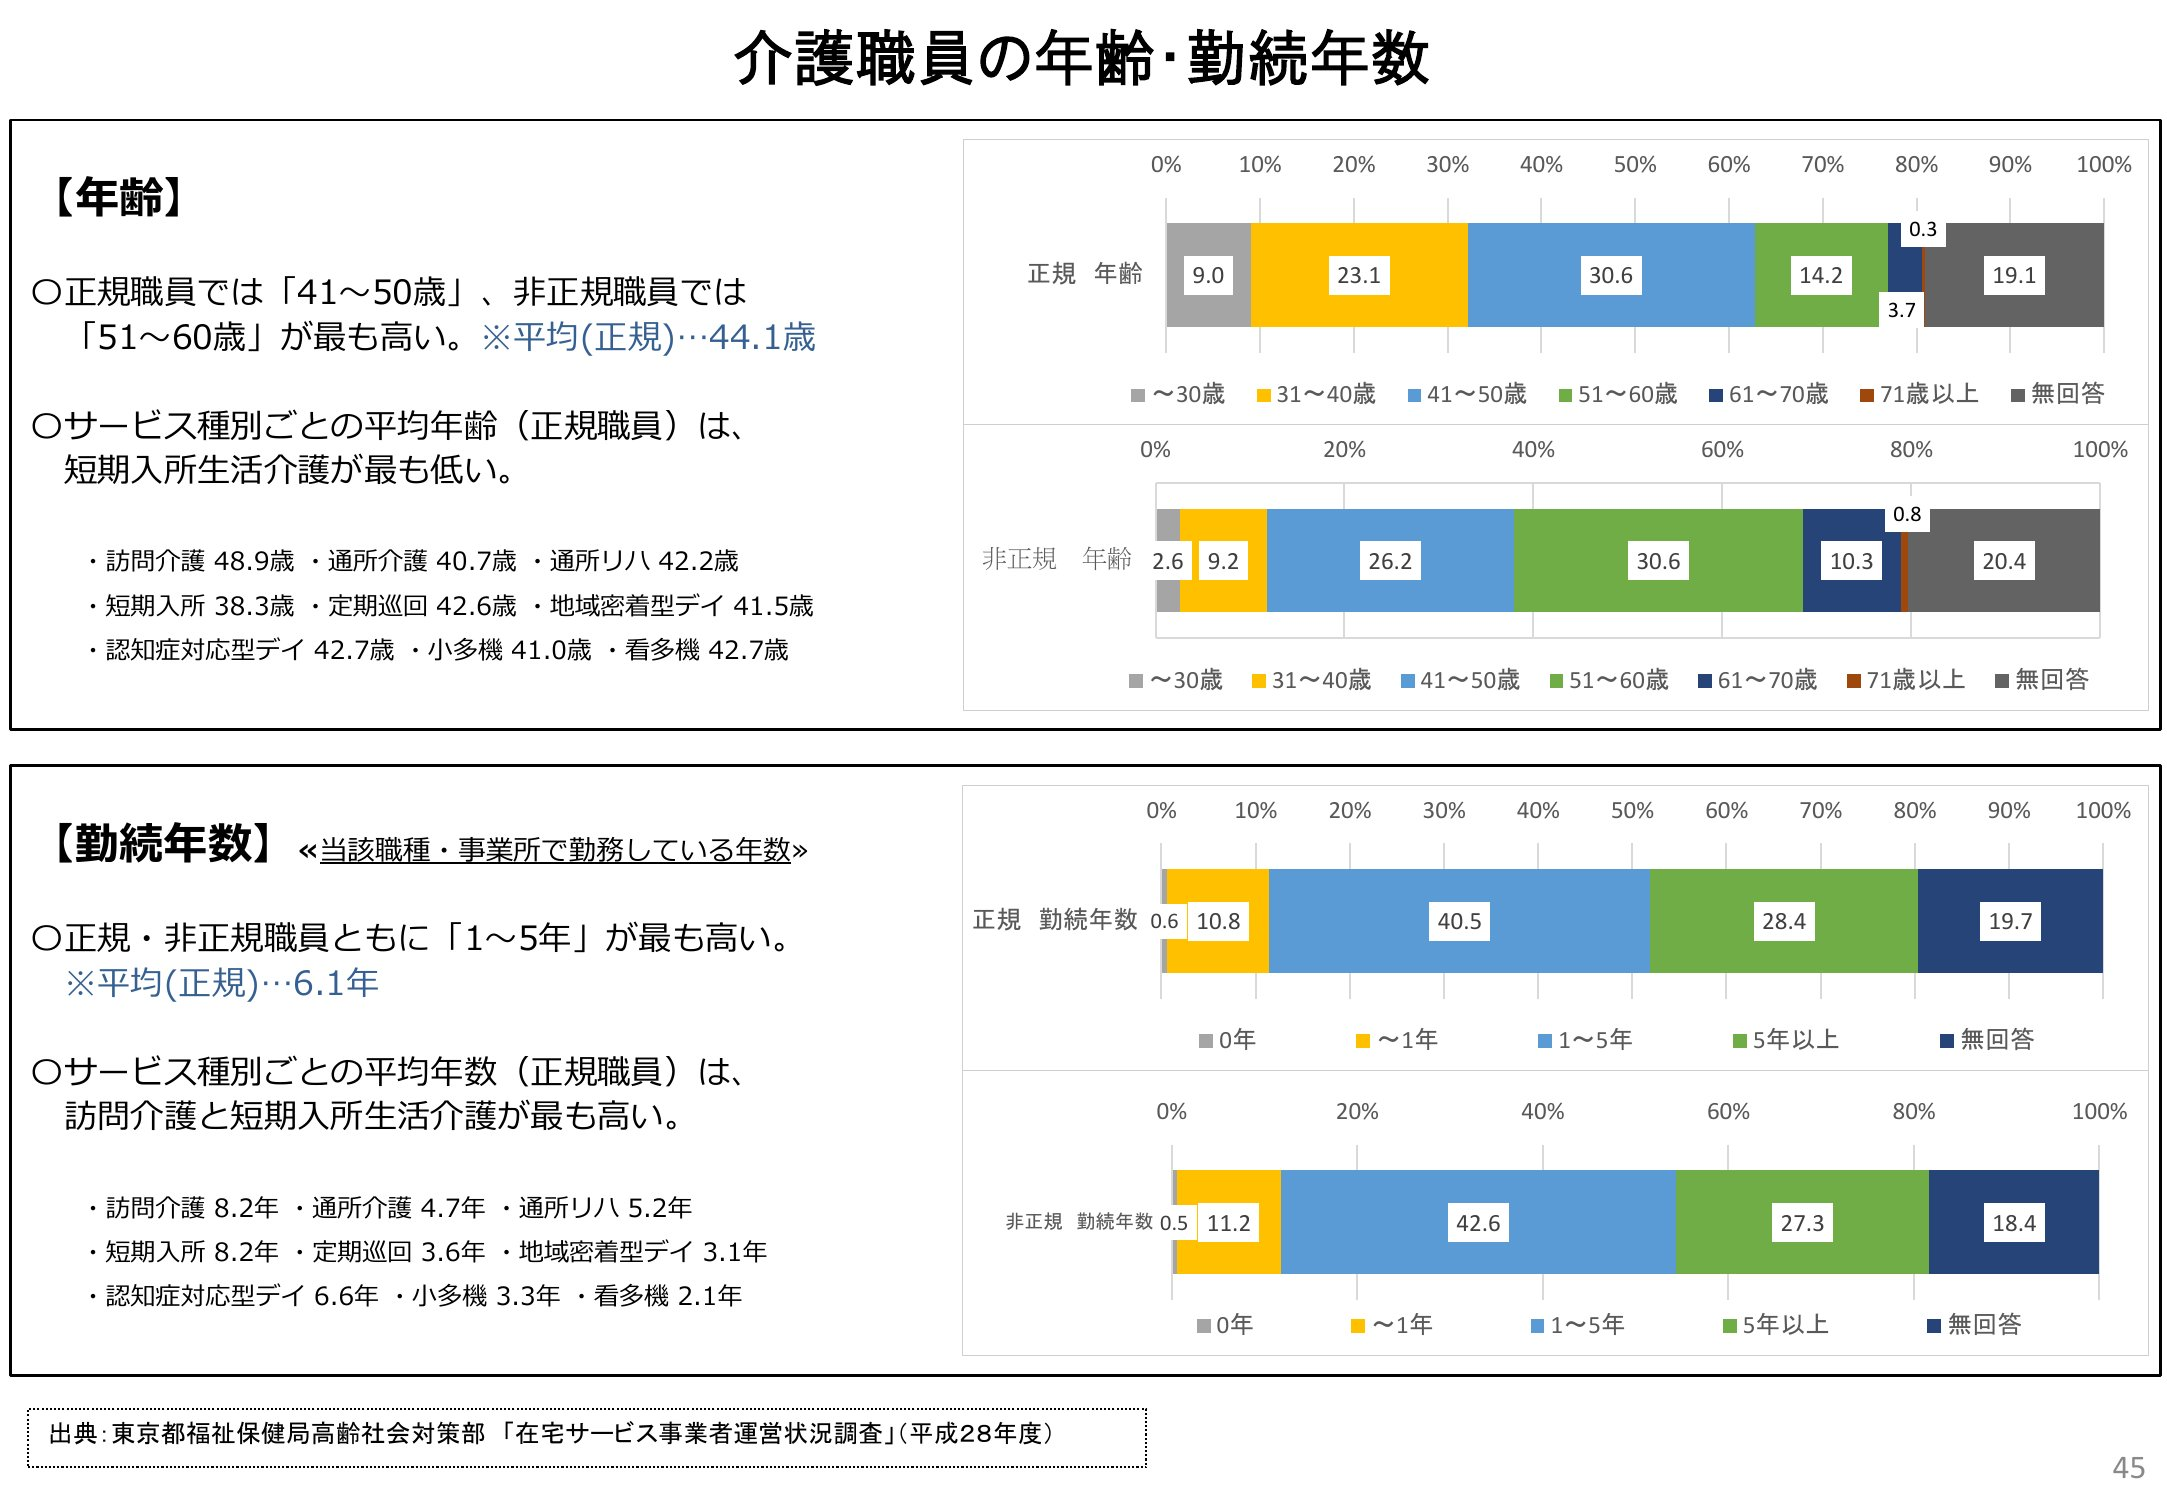

In [95]:
from IPython.display import display, HTML

def display_pages(images, per_row=3):
    grid_style = f"""
    <style>
        .image-grid {{
            display: grid;
            grid-template-columns: repeat({per_row}, 1fr);
            gap: 10px;
        }}
        .image-grid img {{
            max-width: 100%;
            height: auto;
            margin: 5px;
        }}
    </style>
    """
    header = f"<p>Query: {text_query}</p>"
    # Generating the HTML for the images
    images_html = "".join([
        f'<div><img src="data:image/jpeg;base64,{image["encoded_image"]}" />Page: {image["page_num"]}<br>Score: {image["score"]:0.2f}</div>'
        for image in images
    ])

    # Combining the grid container style and the images
    full_html = grid_style + f"<div class='image-grid'>{images_html}</div>"

    display(HTML(full_html))

display_pages(relevant_images)

## Get an answer from GPT

Now we will send the pages of related content to GPT, along with our question.

This is the same as uploading the documents manually, except we found the "relevant pages" through programming.

In [99]:
# Update with your API key
API_KEY='YOUR API KEY GOES HERE'

In [98]:
from openai import OpenAI

client = OpenAI(api_key=API_KEY)

prompt = f"""Using the documents below, answer the
following question. Cite the page and describe/quote where
the answer was found, if possible: \n\n{text_query}"""

image_messages = [{
    "type": "image_url",
    "image_url": {
        "url": f"data:image/jpeg;base64,{image['encoded_image']}"
    }
} for image in relevant_images]

response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": prompt},
        *image_messages,
      ],
    }
  ],
  max_tokens=300,
)

answer_text = response.choices[0].message.content
print(answer_text)

2015年の高齢夫婦世帯数は「18,915世帯」と示されています。これは、最初のページのグラフにおいて、2015年度の数値として記載されています。具体的には、グラフの中で「2015年度」のバーが示す値です。


**Is this the corrent answer???**

You might need to add more documents. But also! ColiPali is specifically trained on English, so will probably perform best with English documents.